In [1]:
import numpy as np
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_state_qsphere, plot_histogram
import qiskit.quantum_info as qi
from qiskit_textbook.tools import array_to_latex
from utils import print_statevector

Q_simulator = Aer.get_backend('qasm_simulator')
U_simulator = Aer.get_backend('unitary_simulator')

# Quantum-Computing Basics using Qiskit's `quantum_info` Module


## Introduction <a id="intro"></a>

I really like Qiskit. As an amateur quantum-computing enthusiast, Qiskit has made my learning experience significantly easier. That being said, when I was first getting started, there were a few things that I found hard to remember or even a bit cumbersome to implement. Fortunately, I have recently found out that some of the functions and classes in Qiskit's [Quantum Information](https://qiskit.org/documentation/apidoc/quantum_info.html) module simplify a lot of these "things" I thought were difficult, making it now my favorite within the Qiskit package. 

In this notebook I want to share some of these findings since I think other people just starting to learn about Qiskit might find them useful. But, if you start going through this document and realize you're fairly familiar with what's being shown, I would still recommend you glance over it; you might find some small feature you didn't know about that might make your life significantly easier!

1. [Generating Statevectors](#gen_sv)    
    1.1 [Using Aer's StateVectorSimulator](#statevec_sim1)    
    1.2 [Using the quantum_info Module](#statevec_1)
2. [Getting Measurement Counts and Probabilities](#get_counts)    
    2.1 [Using Aer's QasmSimulator](#qasm_sim)    
    2.2 [Using the quantum_info Module](#statevec_2)
3. [Operators](#operators)    
    3.1 [Using Aer's UnitarySimulator](#unit_sim)    
    3.2 [Using the quantum_info Module](#qi_ops)
4. [Post-Measurement Operations](#post_meas)    
    4.1 [Using Aer's StateVectorSimulator](#statevec_sim3)    
    4.2 [Using the quantum_info Module](#statevec_3)
5. [Final Notes](#final)
    
## 1. Generating Statevectors <a id="gen_sv"></a>

### 1.1 Using Aer's `StateVectorSimulator` <a id="statevec_sim1"></a>

I learned how to use Qiskit by watching the fantastic Youtube video series [Coding with Qiskit](https://www.youtube.com/playlist?list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY). One of the first things we are taught is how to find the output statevector of a circuit by using the steps I will describe below. A very similar procedure is also presented in Qiskit's documentation [Getting Started with Qiskit](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html) tutorial.

The process is as follows:

We want to create a quantum circuit, and then extract the output state the circuit generates if all input qubits are initialized in the $|0\rangle$ state. Here we will use as an example a circuit that takes the input state $|00\rangle$ and evolves it to the state $ 1/\sqrt{2} \left (|00 \rangle + |11 \rangle \right )$.

So first, we create the circuit:

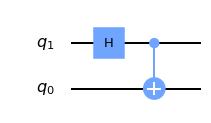

In [2]:
# Create (and draw) quantum circuit
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw('mpl', reverse_bits = True)

Then, we import the [StateVectorSimulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.StatevectorSimulator.html) from the [Aer provider](https://qiskit.org/documentation/apidoc/aer_provider.html) and execute the simulation:

In [3]:
# Import and run the Statevector simulator
S_simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, backend = S_simulator)

And finally, we extract the results and print/visualize the statevector:

In [4]:
# Extract and print results
result = job.result()
state = result.get_statevector()
print_statevector(state)

<IPython.core.display.Math object>

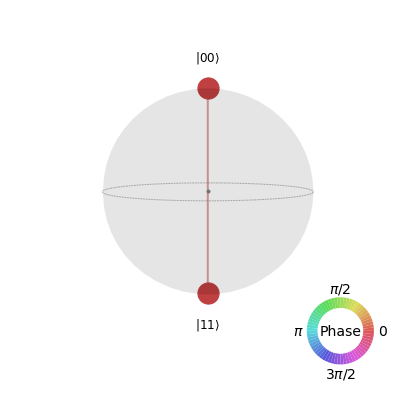

In [5]:
# visualize in the Q sphere
plot_state_qsphere(state)

In summary, between creating our quantum circuit and visualizing the results, we had to perform a total of 4 steps just to extract the output statevector:

1. Import the `statevector_simulator` from the `Aer` provider using the `.get_backend()` class method
2. Run the simulation using the `execute` function
3. Extract the results from the simulation using the `.result()` class method
4. Get the statevector array from our results using the `.get_statevector()` class method

I've always found this process very hard to remember and often find myself going back to other notebooks to copy/paste/modify my code. 

Another issue with this approach is that, if we want to now see how our quantum circuit evolves a different input state, we have to modify the original quantum circuit. For instance, if we want to get the output statevector when our input is the state $|01 \rangle$, we need to now add an $X$ gate on qubit `q0` before passing the state to our circuit, and then re-run the simulation:

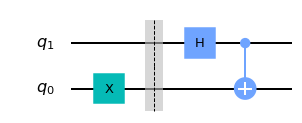

In [6]:
# Create quantum circuit to change input state from |00> to |01>
qc2 = QuantumCircuit(2)
qc2.x(0)
qc2.barrier()

# Attach circuit of interest qc to state initialization circuit qc2
qc2.compose(qc, inplace=True)
qc2.draw('mpl', reverse_bits = True)

In [7]:
# Re-run the Statevector simulation.
job = execute(qc2, backend = S_simulator)

# Extract and print results one more time.
result = job.result()
state2 = result.get_statevector()
print_statevector(state2)

<IPython.core.display.Math object>

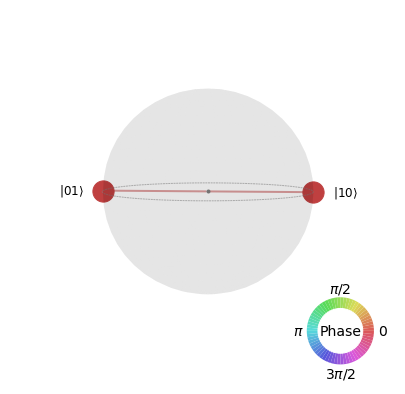

In [8]:
# visualize in the Q sphere
plot_state_qsphere(state2)

Furthermore, if we wanted to see how other input states like $|10 \rangle$, or $|11 \rangle$, or $1/\sqrt{2}(|00\rangle - |11\rangle)$, or any of the other infinite possible superpositions of 2-qubit states, we will have to, once again, create a new circuit to generate the corresponding input state, attach it to the circuit of interest `qc`, and rerun the simulation all over again.

As can be clearly seen, generating statevectors this way required a lot of steps. Luckily for us, the `quantum_info` module offers a much simpler way to do this exact same thing! So let's take a look.

### 1.2 Using the `quantum_info` Module <a id="statevec_1"></a>

An alternative way to perform the same process is by using the `Statevector` class from the `quantum_info` module (imported in `cell 1` as `qi`). For completeness within this section, let's create the same `QuantumCircuit` we had before:

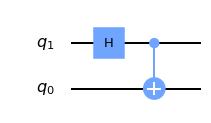

In [9]:
# Create (and draw) quantum circuit
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw('mpl', reverse_bits = True)

Now, to obtain the statevector from the output of a `QuantumCircuit`, we can pass our circuit `qc` to the `.from_instruction()` method of the [Statevector](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html) class as follows:

In [10]:
# Generate and print statevector
sv = qi.Statevector.from_instruction(qc)
print_statevector(sv)

<IPython.core.display.Math object>

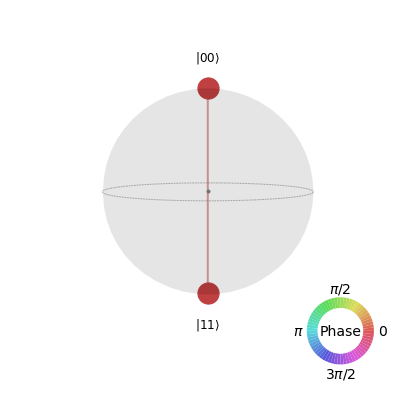

In [11]:
# visualize in the Q sphere
plot_state_qsphere(sv)

That's it! we're Done! We performed the same 4 steps from the previous method with a single line of code: 

`sv = qi.Statevector.from_instruction(qc)` 

If, as before, we wanted to see how the input state $|01\rangle$ evolves through this same circuit, we can actually use the `.from_label()` method to initialize the statevector, and then the `.evolve()` method to pass it through the circuit:

In [12]:
# Initialize stavector, evolve through circuit and print output statevector
sv2 = qi.Statevector.from_label('01')
sv2 = sv2.evolve(qc)
print_statevector(sv2)

<IPython.core.display.Math object>

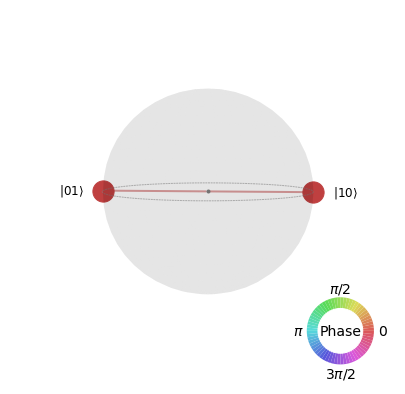

In [13]:
# visualize in the Q sphere
plot_state_qsphere(sv2)

Therefore, by using the `quantum_info` module, we can avoid having to create a separate circuit to prepare our input state (in this example: $|01\rangle$).

In the case where we need to generate a statevector that cannot be represented by the supported labels, we can simply pass a `numpy` array to the `Statevector` that contains the probability amplitdes of each element. For example, for a state like: $1/2|00\rangle - i/\sqrt{2} |01\rangle + 1/2|11 \rangle $ we can create the statevector as follows:

In [14]:
# Create statevector by passing numpy array of probability amplitudes
state_array = np.array([1/2,-1j/np.sqrt(2),0,1/2])
sv3 = qi.Statevector(state_array)
print_statevector(sv3)

<IPython.core.display.Math object>

And, not surprisingly, we can pass the this new statevector `sv3` thru our circuit as before:

In [15]:
# Evolve through circuit and print output statevector
sv3 = sv3.evolve(qc)
print_statevector(sv3)

<IPython.core.display.Math object>

## 2. Getting Measurement Counts and Probabilities <a id="get_counts"></a>

Another Qiskit feature that is taught early on, is the ability to perform several measurements on a circuit to calcualte the probabilities of obtaining a given state. For example, we expect that if we measure many times a one-qubit state in the following superposition: $\sqrt{1/4}|0\rangle + \sqrt{3/4}|1\rangle$, we will obtain state $|0\rangle$ $1/4$ ($25%$) of the times, and state $|1\rangle$ ther remaining $3/4$ (75%) of the times.

### 2.1 Using Aer's `QasmSimulator` <a id="qasm_sim"></a>

The way this is explained in Qiskit's [video series](https://youtu.be/RrUTwq5jKM4) and [documentation tutorial](https://qiskit.org/documentation/getting_started.html) follows very similar steps as those we explained for the statevector simulation explained in the previous section.

First off, we need a circuit that not only has qubits, but also a classical bits that store the measured values. Furthermore, we also need to add measurement instructions, so let's do this in a new circuit `qc_meas`:

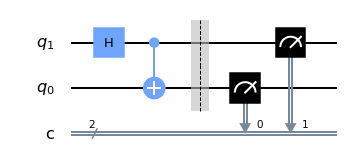

In [16]:
# Create same circuit as qc but with classical bits and measurement elements
qc_meas = QuantumCircuit(2,2) # quantum circuit with 2 quantum qubits and 2 classical bits
qc_meas.h(1)
qc_meas.cx(1,0)
qc_meas.barrier()
qc_meas.measure([0,1],[0,1])
qc_meas.draw(output='mpl', reverse_bits=True)

Next, we import the quantum simulator [QasmSimulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html) from the [Aer provider](https://qiskit.org/documentation/apidoc/aer_provider.html) and execute the simulation:

In [17]:
# Import and run the Qasm simulator
Q_simulator = Aer.get_backend('qasm_simulator')
job_meas = execute(qc_meas, backend = Q_simulator, shots = 128)

And then, we extract the counts and visualize the probabilities in a histogram:

In [18]:
# Extract and print counts
results_meas = job_meas.result()
counts = results_meas.get_counts()
for st in counts:
    print('State', st, 'was measured:', counts[st], 'times')

State 00 was measured: 59 times
State 11 was measured: 69 times


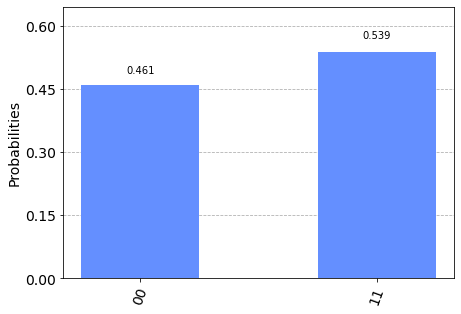

In [19]:
# Display probabilities in histogram
plot_histogram(counts)

To recap, here are the the steps necessary to extract the measurement probabilities of a quantum circuit:

1. Make sure our circuit includes classical bits and measurement elements between the qubits we want to measure, and these new classical bits 
2. Import the `qasm_simulator` from the `Aer` provider using the `.get_backend()` class method
3. Run the simulation using the `execute` function including the number of times (`shots`) we want to perform the measurement
4. Extract the results from the simulation using the `.result()` class method
5. Get the counts number of counts per measured state using the `.get_counts()` class method

Just as with the statevector simulation, this is a long process. Now, as I will discuss later, there are perfectly good reasons why we will like to execute our simulation using the `QasmSimulator`. However, I find that often all I want is to get a quick idea of of the measurement results from a circuit, for which performing these steps can be tedious to implement.

### 2.2 Using the `quantum_info` Module <a id="statevec_2"></a>

The `Statevector` class has some very cool features that can help us get measurement counts much faster than what was described before. 

Let's first remember that statevector `sv` we got in the previous section was the output state of our circuit of interest `qc`:

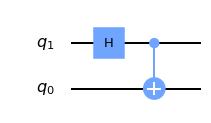

In [20]:
# Create (and draw) quantum circuit
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw('mpl', reverse_bits = True)

In [21]:
# Generate and print statevector
print_statevector(sv)

<IPython.core.display.Math object>

If we want to extract the ideal measurement probabilities for this output state, all we have to do is use either the `.probabilities()` or the `.probabilities_dict()` method as follows:

In [22]:
# Extract and print ideal measurement probabilities for statevector sv
probs = sv.probabilities_dict(decimals=6)
for st in probs:
    print('The ideal probability of measuring', st, 'is:', probs[st])

The ideal probability of measuring 00 is: 0.5
The ideal probability of measuring 11 is: 0.5


We can also sample our state a certain number of times to "emulate" the effect of the state being measured, just as we did in the previous section using the `QasmSimulator`. This can be done using the `.sample_counts()` method, where we pass the number of times we want to sample the state:

In [23]:
# Sample sv to emulate the effect of performing a measurement several times
samples = sv.sample_counts(128)
for st in samples:
    print('State', st, 'was sampled:', samples[st], 'times')

State 00 was sampled: 58 times
State 11 was sampled: 70 times


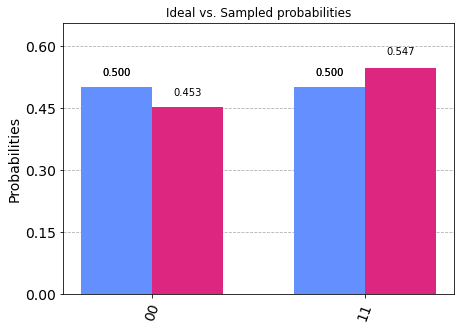

In [24]:
# Plot histogram of ideal and "sampled" probabilities for sv
plot_histogram([probs, samples], title='Ideal vs. Sampled probabilities')

As can be seen, the 5 steps needed to get the counts from a measurement using the `QasmSimulator` can be perfomed with a single line of code:

`samples = sv.sample_counts(128)`

Now, we have to be very clear in that, what we are doing here is **not** the same as what we did with the `QasmSimulator`. Here, we are **not** performing measurements on the quantum circuit, but instead, we are generating the statevector with the circuit `qc` (which didn't have any measurement instructions), and then using the `.sample_counts()` to **emulate** the measurement process.

As a matter of fact, the `.from_instruction()` method from the `Statevector` class does not support classical registers and measurement instructions. So, if for example, we try to generate a statevector from a circuit with measurements (like `qc_meas`) we will get an error:

In [25]:
# this will raise an error because classical registers & measruments are not supported
invalid_sv = qi.Statevector.from_instruction(qc_meas)

QiskitError: 'Cannot apply instruction with classical registers: measure'

This can be a limitation when using the `Statevector.sample_counts()` method, particularly in simulations in which we want to perform a measurement, and then apply quantum gates to the new projected states. As I explain in [section 4](post_meas), we need to use a different type of class method in order to emulate this type of experiments using the `quantum_info` module.

## 3. Operators <a id="operators"></a>

Another important thing to learn when getting started, is to find the operator (unitary matrix) of a quantum circuit. The advantages of using the `quantum_info` module for operators are very similar to those already explained for statevectors, so I won't spend too much time on this.

### 3.1 Using Aer's `UnitarySimulator` <a id="unit_sim"></a>

The way this is explained in the video series is by using Aer's [UnitarySimulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.UnitarySimulator.html) as follows:

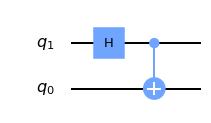

In [26]:
# Create (and draw) quantum circuit
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw('mpl', reverse_bits = True)

In [27]:
# Import and run the Unitary simulator
U_simulator = Aer.get_backend('unitary_simulator')
job_u = execute(qc, backend = U_simulator)

# Extract and print results
result_u = job_u.result()
unitary = result_u.get_unitary()
array_to_latex(unitary)

<IPython.core.display.Math object>

### 3.1 Using the `quantum_info` Module <a id="qi_ops"></a>

These 4 steps can again be performed with a single line of code using the `Operator` class from the `quantum_info` module as follows:

In [28]:
# Generate and print operator
u = qi.Operator(qc)
array_to_latex(u.data)

<IPython.core.display.Math object>

Notice that here I had to use the `.data` method to print my results using the `array_to_latex` function installed from the `qiskit_textbook` [package](https://github.com/qiskit-community/qiskit-textbook). This is because the `.Operator` method returns an object of type `Opertor`, which is not supported by `array_to_latex`. So to extract the `numpy` array we can always use `.data`; this also applies to the `Statevector`:

In [29]:
print('This is a Statevector: \n\n', sv, '\n\n And this is its `numpy` array: \n\n', sv.data)

This is a Statevector: 

 Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2)) 

 And this is its `numpy` array: 

 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


# 4. Post-Measurement Operations <a id="post_meas"></a>

Another scenario we might encounter when simulating quantum circuits, is that of applying gates to states that have projected after measurements. Let's consider, for example, the case in which we want to generate, at random and with equal probability, the four Bell states:

$$ 
\begin{aligned}
&|\Phi^{+} \rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right )
&|\Phi^{-} \rangle = \frac{1}{\sqrt{2}} \left( |00\rangle - |11\rangle \right )
\\
\\
&|\Psi^{+} \rangle = \frac{1}{\sqrt{2}} \left( |01\rangle + |10\rangle \right )
&|\Psi^{-} \rangle = \frac{1}{\sqrt{2}} \left( |01\rangle - |10\rangle \right )
\end{aligned}
$$

One way we can do this is with the following steps:

1. Create a quantum circuit that puts a state in an equal supeposition of states $|00\rangle, |01\rangle, |10\rangle, |11\rangle$; i.e., generates the state: 

$$ |\psi_1\rangle = \frac{1}{2} \left(|00\rangle + |01\rangle + |10\rangle + |11\rangle \right) $$

2. Perfom a measurement of state $|\psi_1\rangle$, which guarantes the projection of the state onto one of the four possible outcomes with equal probability: 

$$ 
|\psi_2\rangle = |00\rangle \quad \text{or}  \quad  |\psi_2\rangle = |01\rangle \quad \text{or}  \quad  |\psi_2\rangle = |10\rangle \quad \text{or} \quad |\psi_2\rangle = |11\rangle 
$$

3. Use the measured state as the input to a Bell-State-generating circuit, to get one of the following states with equal probability:

$$ 
|\psi_3\rangle = |\Phi^{+} \rangle \quad \text{or}  \quad  |\psi_3\rangle = |\Phi^{-} \rangle \quad \text{or}  \quad  |\psi_3\rangle = |\Psi^{+} \rangle \quad \text{or} \quad |\psi_3\rangle = |\Psi^{-} \rangle
$$

Now let's see how this can be done using both the `StateVectorSimulator` and the `Statevector` class from the `quantum_info` module.

### 4.1 Using Aer's `StateVectorSimulator` <a id="statevec_sim3"></a>

The circuit below, shows each of the steps separated by barriers which are included by the use of [snapshots](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.snapshot.html) that allow us to label and extract statevectors $|\psi_1\rangle$ and $|\psi_2\rangle $, which are at intermediate points in the circuit, and $|\psi_3\rangle $ at the output:

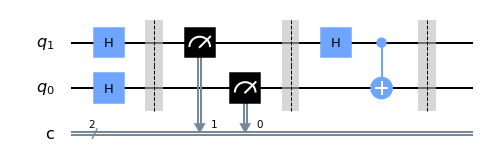

In [30]:
qc_rand_bell = QuantumCircuit(2,2)
qc_rand_bell.h([1,0])
qc_rand_bell.snapshot('psi_1')
qc_rand_bell.measure([1,0],[1,0])
qc_rand_bell.snapshot('psi_2')
qc_rand_bell.h(1)
qc_rand_bell.cx(1,0)
qc_rand_bell.snapshot('psi_3')
qc_rand_bell.draw(output='mpl', reverse_bits=True)

We can now run this using the simulator for a few shots and look at our results:

In [31]:
job = execute(qc_rand_bell, backend = Q_simulator, shots = 10)

# Extract and print results
result = job.result()
snaps = result.data(qc_rand_bell).get('snapshots') # get dictionary with all snapshot results
state_vec = snaps.get('statevector') # dictionary containing all statevectors for every shot

# print results:
print('For every shot, state psi_1 is always equal to:')
print_statevector(state_vec.get('psi_1')[0], pretext="| \psi_{1} \\rangle = ")

print('Results for state psi_2 for each shot:')
for sv_shot in state_vec.get('psi_2'):
    print_statevector(sv_shot, pretext="| \psi_{2} \\rangle = ")

print('Results for state psi_3 for each shot:')
for sv_shot in state_vec.get('psi_3'):
    print_statevector(sv_shot, pretext="| \psi_{3} \\rangle = ")

For every shot, state psi_1 is always equal to:


<IPython.core.display.Math object>

Results for state psi_2 for each shot:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Results for state psi_3 for each shot:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As can be seen, this procedure does result in a state $|\psi_3\rangle$ equal to one of the four possible Bell states at random.

### 4.2 Using the `quantum_info` Module  <a id="statevec_3"></a>

The same results can be accomplished by using the `quantum_info` module with a few lines of code.

First off, to generate the state in equal superpositon $|\psi_1\rangle$, we can use the `.from_label()` method as follows:

In [32]:
psi_1 = qi.Statevector.from_label('++')
print_statevector(psi_1)

<IPython.core.display.Math object>

Next, we can use the `.measure()` method to "project" $|\psi_1\rangle$, onto one of the four possible states $|\psi_2\rangle$. And then, we can use the `.evolve()` method to pass state $|\psi_2\rangle$ through the Bell-state-generating circuit `qc` to obtain one of the four possible Bell states $|\psi_3\rangle$.

We can do this all within a for loop to capture more than one "shot":

In [33]:
print('Results for state psi_3 for each shot:')
shots = 10
for shot in range(shots):
    psi_2 = psi_1.measure()[1]
    psi_3 = psi_2.evolve(qc)
    print_statevector(psi_3, pretext="| \psi_{3} \\rangle = ")

Results for state psi_3 for each shot:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Notice that here we had to use the `.measure()` method inside a loop rather than the `.sample_counts()` because what we want is the projected quantum state after a measurement, and not the values of the classic bits.

## 5. Final Notes  <a id="final"></a>

This notebook highlights how using the `quantum_info` module can provide the advantage of simplifying code when trying to quickly find output statevectors, get state counts from measurements, or finding the unitary matrix of a circuit. There are, however, scenarios in which we do want to use the `StateVectorSimulator` and `QasmSimulator` over the `Statevector` class. In particular, when trying to simulate circuits in the presence of noise, the simulators are the obvious choice. 

It is also important to mention that the `quantum_info` module offers many more sophisticated features than the ones presented here, like the ability to work with Density Matrices, Super Operators, different state measures, and more. This [youtube video](https://youtu.be/VvP41TwY34o) outlines some of these, but please refer to [Qiskit's documentation](https://qiskit.org/documentation/apidoc/quantum_info.html) for a full list of what's available.

Thanks for reading,

### DIEGO EMILIO SERRANO
https://twitter.com/diemilioser